In [11]:
from collections import Counter
from collections import namedtuple, defaultdict
from pprint import pprint
from itertools import groupby, permutations
from copy import deepcopy
import re

import matplotlib.pyplot as plt
from Bio import SeqIO
from tqdm import tqdm_notebook

from vdj_walker import *

%matplotlib inline

In [3]:
"""Define constants"""
KMER_LEN = 7
PAIR_TRESHOLD = 15
COOL_TRESHOLD = 25
IMP_TRESHOLD = 10

"""Define data types"""
D = namedtuple('D', ['gene', 'J_gene', 'V_gene'])
Comb = namedtuple('Comb', ['gene', 'pos'])
DGene = namedtuple('DGene', ['read', 'gene'])
Kmer = namedtuple('Kmer', ['seq', 'j', 'v', 'dataset'])

def get_fa_header_value(line, *, index):
    return line.split('|')[index].split(':')[1]

def read_fa(file):
    for record in SeqIO.parse(file, 'fasta'):
        yield str(record.seq)

def read_J(file):
    for record in SeqIO.parse(file, 'fasta'):
        id_ = get_fa_header_value(record.id, index=1)
        if id_.startswith('cluster'):
           seq_len = len(str(record.seq).replace('-', ''))
        else:
            yield Comb(id_, seq_len)

def read_genes(file):
    for record in SeqIO.parse(file, 'fasta'):
        gene = record.id
        read = str(record.seq).upper()
        yield DGene(read, gene)

def read_V_headers(file):
    length = 0
    for record in SeqIO.parse(file, 'fasta'):
        if 'READ' in record.id:
            length = int(get_fa_header_value(record.id, index=3))
        elif 'GENE' in record.id:
            gene = get_fa_header_value(record.id, index=1)
            yield Comb(gene, length)

def split_kmers(read, size):
    for i in range(len(read) - size + 1):
        kmer = read[i : i + size]
        yield kmer

def read_info(csv):
    for line in csv:
        atrs = line.split()
        v = Comb(atrs[4], int(atrs[2]) - 1)
        j = Comb(atrs[8], int(atrs[5]) - 1)
        yield (v, j)

def fetch_d(vdj_dir: Path, i):
    clean_reads = read_fa(open(vdj_dir / 'cleaned_reads.fasta', 'r'))
    info = read_info(open(vdj_dir / 'alignment_info.csv'))
    
    for read, (v, j) in zip(clean_reads, info):
        d_read = read[v.pos + 1 : j.pos]
        yield (d_read, (j.gene, v.gene, i))

def read_iter():
    for i, vdj_dir in enumerate(vdj_dir_iter()):
        for read, info in fetch_d(vdj_dir, i):
            yield (read, info)

In [4]:
"""Kmers in known D segments"""
Ds = list(read_genes(open(gene_dir / 'IGHD-allP.fa', 'r')))
l = 0
n = 0
ds_kmers = set()
for i in Ds:
    l += len(i.read)
    n += 1
    for kmer in split_kmers(i.read, KMER_LEN):
        ds_kmers.add(kmer)
print(l / n)

24.318181818181817


In [5]:
"""Cut D segments from all datasets"""
raw_kmers = Counter()
for read, info in read_iter():
    for seq in split_kmers(read, KMER_LEN):
        raw_kmers[Kmer(seq, *info)] += 1

len(raw_kmers)

3039905

In [6]:
"""Count kmer pairs and delete kmers with less than PAIR_TRESHOLD number of occurences"""
kmer_pairs = Counter()
for kmer, n in raw_kmers.items():
    if n > PAIR_TRESHOLD:
        kmer_pairs[kmer.seq] += 1

len(kmer_pairs)

8350

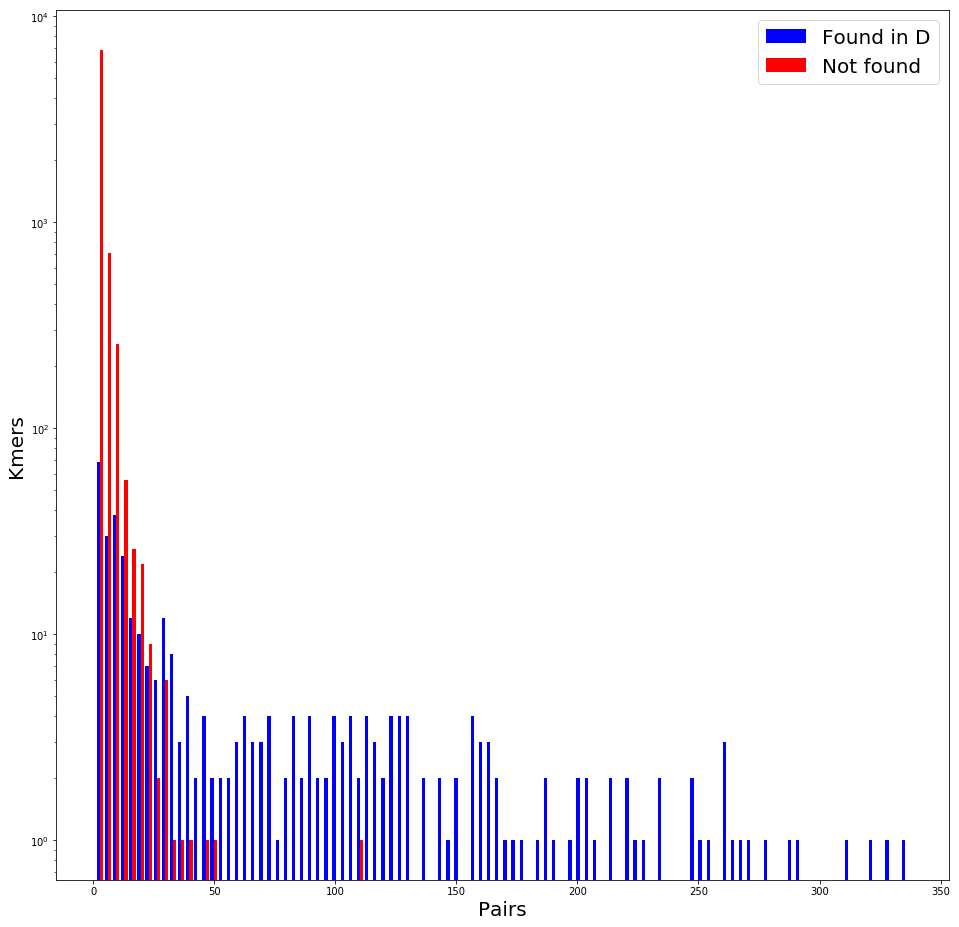

In [7]:
vdj_plot = plt.figure(figsize=(16, 16))

def ordinary_kmers():
    for q, i in kmer_pairs.items():
        if q in ds_kmers:
            yield i
        
def unique_kmers():
    for q, i in kmer_pairs.items():
        if q not in ds_kmers:
            yield i

plt.hist([ordinary_kmers() |> list, unique_kmers() |> list], 100, 
         alpha=1, color=['b', 'r'], label=['Found in D', 'Not found'], log=True)

plt.xlabel('Pairs', fontsize=20)
plt.ylabel('Kmers', fontsize=20)
plt.legend(fontsize=20)

In [8]:
"""Filter kmers with small number of pairs"""
good = set()
for kmer, n in kmer_pairs.items():
    if n >= 20:
        good.add(kmer)
print(len(good))
good

211


{'AACTGGA',
 'ACAGCTA',
 'ACCAGCT',
 'ACGATTT',
 'ACGGTGA',
 'ACGGTGG',
 'ACTACGG',
 'ACTATGA',
 'ACTATGG',
 'ACTGGAA',
 'ACTGGTT',
 'AGATGGC',
 'AGCAGCA',
 'AGCAGCT',
 'AGCAGTG',
 'AGCTACT',
 'AGCTATG',
 'AGCTCGT',
 'AGCTGCC',
 'AGCTGCT',
 'AGCTGGT',
 'AGGGGGG',
 'AGTACCA',
 'AGTAGTA',
 'AGTAGTG',
 'AGTGGCT',
 'AGTGGGA',
 'AGTGGTG',
 'AGTGGTT',
 'AGTTATT',
 'ATACAGC',
 'ATAGCAG',
 'ATAGTAG',
 'ATAGTGG',
 'ATATTGT',
 'ATATTTT',
 'ATGATAG',
 'ATGGCTA',
 'ATGGTTA',
 'ATGGTTC',
 'ATTACGA',
 'ATTACTA',
 'ATTGTAG',
 'ATTTTGA',
 'ATTTTTG',
 'CAGCAGC',
 'CAGCTAT',
 'CAGCTCG',
 'CAGCTGC',
 'CAGCTGG',
 'CAGTGGC',
 'CCAGCTG',
 'CGATATT',
 'CGATTTT',
 'CGGGGAG',
 'CGGGGGG',
 'CGGTGAC',
 'CGGTGGT',
 'CGTATTA',
 'CTACAAT',
 'CTACGAT',
 'CTACGGT',
 'CTATGAT',
 'CTATGGT',
 'CTGCTAC',
 'CTGCTAT',
 'CTGGAAC',
 'CTGGTAC',
 'CTGGTTA',
 'GACTACG',
 'GACTGGT',
 'GAGATGG',
 'GAGCTAC',
 'GAGTGGT',
 'GAGTTAT',
 'GATACAG',
 'GATAGCA',
 'GATAGTA',
 'GATATTG',
 'GATATTT',
 'GATGGCT',
 'GATTACT',
 'GATTTTT',
 'GC

In [9]:
def read_imp(read):
    for kmer in split_kmers(read, KMER_LEN):
        if kmer not in ds_kmers:
            if kmer in good:
                yield kmer_pairs[kmer]
            else:
                yield 0
        else:
            yield kmer_pairs[kmer]

def is_good(n):
    return n >= IMP_TRESHOLD

def split_read(read):
    global bad_counter, distribution, max_seq_counter
    
    read_map = list(enumerate(read_imp(read) |> map$(is_good, ?)))
    
    for i, imp_id in read_map:
        distribution[i][int(imp_id)] += 1
        
    bad_counter += len(list(filter((x)->not x[1], read_map)))
    
    gb = groupby(read_map, (x)->x[1])
    gb = gb |> map$((x)->(x[0], list(x[1])), ?) |> list
    max_good_seq = 0
    for ids in filter((x)->x[0], gb):
        ids = ids[1] |> map$((x)->x[0], ?) |> list
        max_good_seq = max(max_good_seq, len(ids))
        yield read[ids[0]:(ids[-1] + KMER_LEN)]
    if max_good_seq > 0:
        max_seq_counter[max_good_seq] += 1

In [ ]:
"""DEBUG - don't eval"""
kmer_pairs_real = deepcopy(kmer_pairs)
good_real = deepcopy(good)

bad_counter = 0
KMER_LEN = 2
IMP_TRESHOLD = 1
kmer_pairs = Counter({'AC': 2, 'CG': 3, 'GA': 2,
                      'AT': 3, 'TC': 2, 'CA': 2})
good = kmer_pairs.keys()
seq = 'AACGAATCATT'

In [190]:
"""After Debug exec:"""
kmer_pairs = kmer_pairs_real
good = good_real
IMP_TRESHOLD = 5

In [51]:
"""Clean trash from d segments"""
bad_counter = 0
cleaned_reads = defaultdict(set)
before_len = Counter()
after_len = Counter()
distribution = [[0, 0] for _ in range(200)]
max_seq_counter = Counter()

for read, info in read_iter():
    before_len[len(read)] += 1
    for clean_read in split_read(read):
        after_len[len(clean_read)] += 1
        cleaned_reads[clean_read].add(info)

print(len(cleaned_reads))
print(bad_counter)

7452
5098386


In [48]:
cleaned_reads = {'ACG': {1, 2, 3}, 'CG': {2, 3, 4}, 'G': {3, 4, 5}}

In [49]:
def remove_pair():
    global cleaned_reads
    deleted = s{}
    for seg1, seg2 in permutations(cleaned_reads.keys(), 2):
        if any(seg in deleted for seg in (seg1, seg2)):
            continue
        if seg2 in seg1:
            #print(seg1, seg2)
            cleaned_reads[seg1] |= cleaned_reads[seg2]
            del cleaned_reads[seg2]
            deleted.add(seg2)
    return

In [52]:
remove_pair()
cleaned_reads

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [55]:
"""Filter kmers with small number of pairs"""
cool = set()
for kmer, n in kmer_pairs.items():
    if kmer not in ds_kmers and n >= COOL_TRESHOLD:
        cool.add(kmer)
print(len(cool))
cool

14


{'AGGGGGG',
 'CGGGGGG',
 'CGTATTA',
 'GCTACGG',
 'GGCTGGC',
 'GGGGAGC',
 'GGGGGGA',
 'GGGGGGG',
 'GGGGGGT',
 'GGGGTGG',
 'GGTGGGA',
 'TGGGGGG',
 'TGGTACC',
 'TGGTACG'}

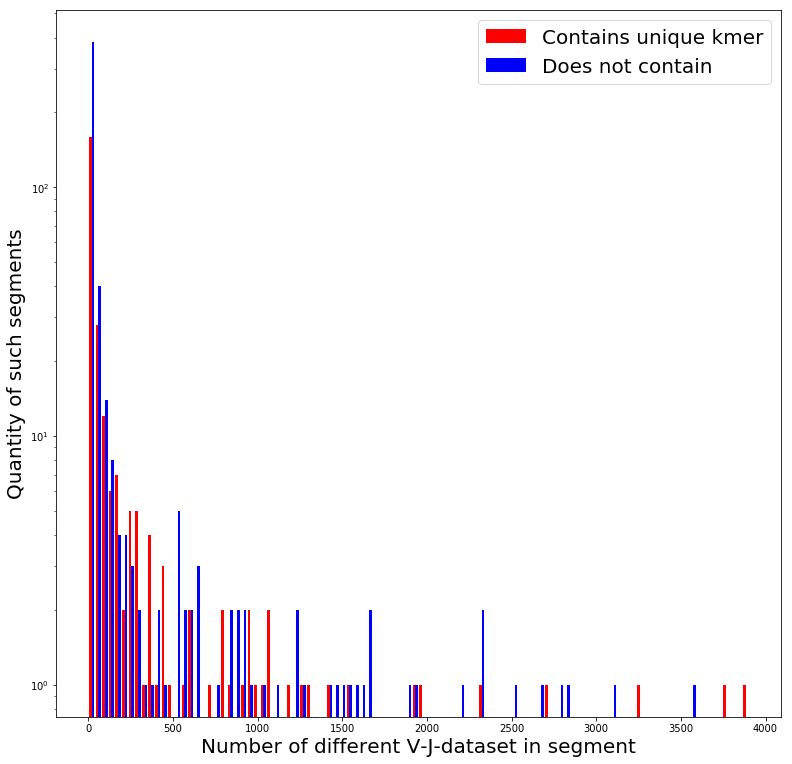

In [56]:
cleaned_plot = plt.figure(figsize=(13, 13))

def xs(cont):
    for read, infos in cleaned_reads.items():
        #if len(infos) > 1000: continue
        if any(kmer in read for kmer in cool) == cont:
            yield len(infos)

_ = plt.hist([xs(True) |> list, xs(False) |> list], bins=100, 
             color=['r', 'b'], log=True, label=['Contains unique kmer', 'Does not contain'])
plt.xlabel('Number of different V-J-dataset in segment', fontsize=20)
plt.ylabel('Quantity of such segments', fontsize=20)
plt.legend(fontsize=20)

In [57]:
cleaned_reads.items()$[:10] |> list

[('CGGGGGGGAT',
  {('IGHJ1*01', 'IGHV1-69*12', 10),
   ('IGHJ1*01', 'IGHV4-31*03', 8),
   ('IGHJ1*01', 'IGHV4-38-2*02', 4),
   ('IGHJ2*01', 'IGHV3-21*01', 15),
   ('IGHJ2*01', 'IGHV3-7*03', 12),
   ('IGHJ2*01', 'IGHV3-72*01', 16),
   ('IGHJ2*01', 'IGHV4-34*01', 6),
   ('IGHJ2*01', 'IGHV4-4*07', 16),
   ('IGHJ2*01', 'IGHV4-59*01', 5),
   ('IGHJ2*01', 'IGHV4-59*01', 8),
   ('IGHJ3*02', 'IGHV1-18*01', 1),
   ('IGHJ3*02', 'IGHV1-18*01', 5),
   ('IGHJ3*02', 'IGHV1-24*01', 6),
   ('IGHJ3*02', 'IGHV1-46*01', 5),
   ('IGHJ3*02', 'IGHV1-69*01', 13),
   ('IGHJ3*02', 'IGHV1-69*04', 9),
   ('IGHJ3*02', 'IGHV1-69*09', 5),
   ('IGHJ3*02', 'IGHV1-69*12', 10),
   ('IGHJ3*02', 'IGHV1-69*12', 17),
   ('IGHJ3*02', 'IGHV1-69D*01', 13),
   ('IGHJ3*02', 'IGHV2-70*01', 8),
   ('IGHJ3*02', 'IGHV3-11*01', 5),
   ('IGHJ3*02', 'IGHV3-11*01', 8),
   ('IGHJ3*02', 'IGHV3-11*05', 11),
   ('IGHJ3*02', 'IGHV3-11*06', 4),
   ('IGHJ3*02', 'IGHV3-13*04', 10),
   ('IGHJ3*02', 'IGHV3-21*01', 4),
   ('IGHJ3*02', 'IGHV3-21*0

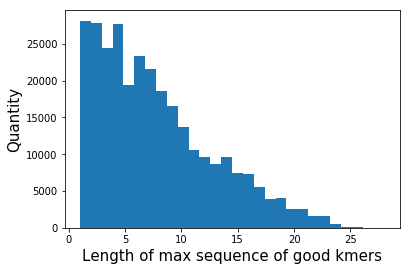

In [58]:
max_seq_plot = plt.figure()
_ = plt.hist(max_seq_counter.elements() |> list, bins=28)
plt.xlabel('Length of max sequence of good kmers', fontsize=15)
plt.ylabel('Quantity', fontsize=15)

In [285]:
max_seq_plot.savefig('max_good_seq2.png')

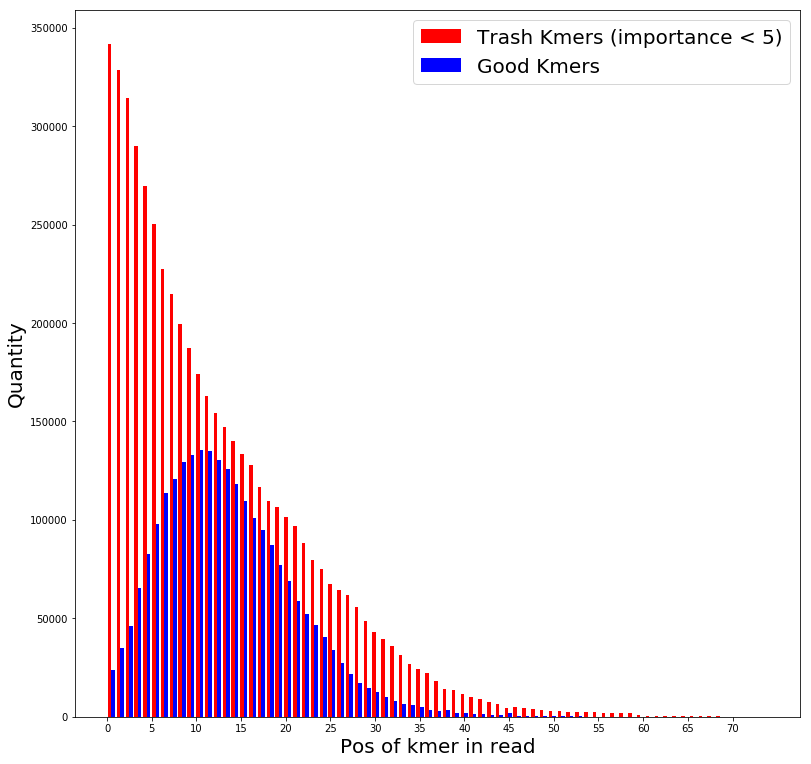

In [16]:
dist_fig = plt.figure(figsize=(13, 13))

def sts(n):
    for i in range(75):
        hmuch = distribution[i][n]
        for j in range(hmuch):
            yield i

trash, read_d = (list(sts(i)) for i in range(2))
_ = plt.hist([trash, read_d], bins = 75, color=('r', 'b'), log=False,
             label=('Trash Kmers (importance < 5)', 'Good Kmers'))

plt.xlabel('Pos of kmer in read', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.legend(fontsize=20)
_ = plt.xticks(range(0, 75, 5))

In [246]:
dist_fig.savefig('importance_distribution.png')

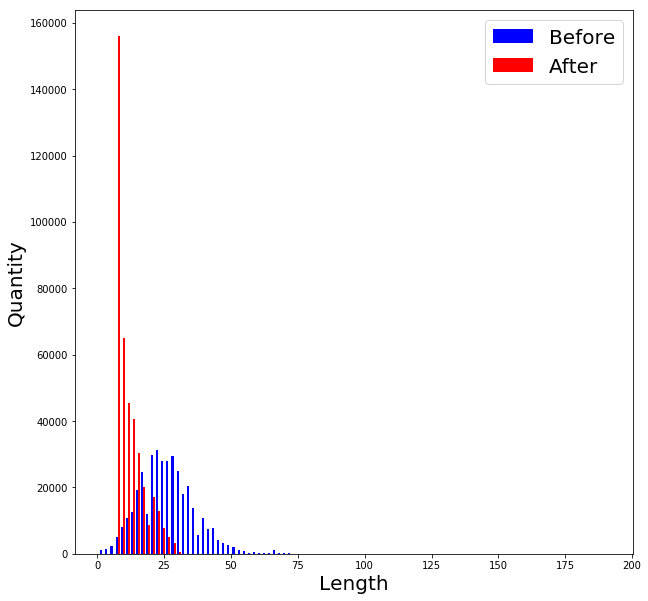

In [18]:
len_plot = plt.figure(figsize=(10, 10))

plt.hist([before_len.elements() |> list, after_len.elements() |> list], 100,
         alpha=1, color=['b', 'r'], label=['Before', 'After'], log=False)

plt.xlabel('Length', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.legend(fontsize=20)
#plt.xticks(range(100, 100))

In [128]:
len_plot.savefig('len2.png')

In [ ]:
kmer_id = {kmer: i for kmer, i in zip(cool, range(len(cool)))}
kmer_id

In [20]:
"""Dict [read]: kmers in it (combination of)"""
cool_reads = {}
for read, info in cleaned_reads:
    n = tuple(kmer for kmer in cool if kmer in read)
    if n:
        cool_reads[(read, info)] = n

len(cool_reads)

26027

In [22]:
"""Dict [combination of kmers]: reads with it"""
comb_reads = defaultdict(list)
for read, comb in cool_reads.items():
    comb_reads[comb].append(read)

print(len(comb_reads))
comb_reads

48


defaultdict(list,
            {('AGGGGGG',): [('TAGGGGGG', ('IGHJ2*01', 'IGHV3-48*04', 12)),
              ('AGGGGGG', ('IGHJ4*02', 'IGHV5-51*01', 5)),
              ('AGGGGGG', ('IGHJ4*02', 'IGHV4-59*01', 8)),
              ('AGGGGGGC', ('IGHJ3*02', 'IGHV3-21*04', 9)),
              ('AGGGGGG', ('IGHJ4*02', 'IGHV1-2*02', 0)),
              ('AGGGGGGC', ('IGHJ4*02', 'IGHV4-39*07', 15)),
              ('AGGGGGGC', ('IGHJ4*02', 'IGHV3-33*06', 11)),
              ('TAGGGGGGC', ('IGHJ4*02', 'IGHV5-51*01', 0)),
              ('AGGGGGG', ('IGHJ4*02', 'IGHV3-74*01', 16)),
              ('TAGGGGGG', ('IGHJ5*02', 'IGHV1-18*01', 17)),
              ('AGGGGGGC', ('IGHJ4*02', 'IGHV4-39*01', 11)),
              ('AGGGGGGC', ('IGHJ4*02', 'IGHV3-30*15', 6)),
              ('AGGGGGGC', ('IGHJ4*02', 'IGHV4-31*03', 15)),
              ('AGGGGGGC', ('IGHJ4*02', 'IGHV3-33*01', 5)),
              ('TAGGGGGG', ('IGHJ5*02', 'IGHV3-30*06', 17)),
              ('AGGGGGGC', ('IGHJ6*03', 'IGHV3-66*01', 9)),
    

In [57]:
cool_combs = Counter()
for comb in cool_reads.values():
    cool_combs[comb] += 1

In [23]:
"""Filter combs where all reads there are from one dataset."""
cool_dataset = {read: combs for read, combs in comb_reads.items()
                if len(set(map((x)->x[1][2], combs))) != 1}
print(len(cool_dataset.keys()))
#cool_dataset = [kmers for kmers in cool_dataset.keys() if len(kmers) != 1]

48


In [26]:
all_reads = {comb: reads for comb, reads in cool_dataset.items()
             if len(comb) > 3}
len(all_reads)

6

In [27]:
cool_vj = {read: combs for read, combs in cool_dataset.items()
           if len(set(map((x)->x[1][:2], combs))) != 1}
print(len(cool_vj))
cool_vj

48


{('AGGGGGG',): [('TAGGGGGG', ('IGHJ2*01', 'IGHV3-48*04', 12)),
  ('AGGGGGG', ('IGHJ4*02', 'IGHV5-51*01', 5)),
  ('AGGGGGG', ('IGHJ4*02', 'IGHV4-59*01', 8)),
  ('AGGGGGGC', ('IGHJ3*02', 'IGHV3-21*04', 9)),
  ('AGGGGGG', ('IGHJ4*02', 'IGHV1-2*02', 0)),
  ('AGGGGGGC', ('IGHJ4*02', 'IGHV4-39*07', 15)),
  ('AGGGGGGC', ('IGHJ4*02', 'IGHV3-33*06', 11)),
  ('TAGGGGGGC', ('IGHJ4*02', 'IGHV5-51*01', 0)),
  ('AGGGGGG', ('IGHJ4*02', 'IGHV3-74*01', 16)),
  ('TAGGGGGG', ('IGHJ5*02', 'IGHV1-18*01', 17)),
  ('AGGGGGGC', ('IGHJ4*02', 'IGHV4-39*01', 11)),
  ('AGGGGGGC', ('IGHJ4*02', 'IGHV3-30*15', 6)),
  ('AGGGGGGC', ('IGHJ4*02', 'IGHV4-31*03', 15)),
  ('AGGGGGGC', ('IGHJ4*02', 'IGHV3-33*01', 5)),
  ('TAGGGGGG', ('IGHJ5*02', 'IGHV3-30*06', 17)),
  ('AGGGGGGC', ('IGHJ6*03', 'IGHV3-66*01', 9)),
  ('AGGGGGG', ('IGHJ3*02', 'IGHV4-59*08', 8)),
  ('TAGGGGGGC', ('IGHJ6*02', 'IGHV4-34*02', 5)),
  ('TAGGGGGG', ('IGHJ5*02', 'IGHV1-2*04', 3)),
  ('AGGGGGGC', ('IGHJ5*02', 'IGHV1-69*09', 5)),
  ('AGGGGGG', ('IGHJ4*0

In [28]:
def viz(read, kmers):
    print(read)
    for kmer in kmers:
        for pos in (m.start() for m in re.finditer(kmer, read)):
            print(' ' * (pos - 1), kmer)
    print()

for comb, reads in all_reads.items():
    for read in reads:
        viz(read[0], comb)

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGCTA
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGGGAGCT
 TGGGGGG
 GGGGGGG
      GGGGAGC
    GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGGAGCTACTC
 TGGGGGG
 GGGGGGG
     GGGGAGC
   GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TTGGGGGGGAGCTAC
 TGGGGGG
  GGGGGGG
     GGGGAGC
   GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

GTTTGGGGGGGAGC
   TGGGGGG
    GGGGGGG
       GGGGAGC
     GGGGGGA

TGGGGGGGGAGCTACTC
 TGGGGGG
 GGGGGGG
     GGGGAGC
   GGGGGGA

TGGGGGGGAGCT
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TGGGGGGGAGC
 TGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

TTGGGGGGGGGGGAGC
 TGGGGGG
  GGGGGGG
         GGGGAGC

    GGGGAGC
  GGGGGGA

CGGGGGGGGGGGGAGC
 CGGGGGG
 GGGGGGG
         GGGGAGC
       GGGGGGA

CGGGGGGGAGCTAC
 CGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

CGGGGGGGAGCT
 CGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

CGGGGGGGGGAGCTA
 CGGGGGG
 GGGGGGG
      GGGGAGC
    GGGGGGA

CGGGGGGGAGCTAC
 CGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

CGGGGGGGGAGCTACT
 CGGGGGG
 GGGGGGG
     GGGGAGC
   GGGGGGA

CGGGGGGGGGAGC
 CGGGGGG
 GGGGGGG
      GGGGAGC
    GGGGGGA

CGGGGGGGGAGC
 CGGGGGG
 GGGGGGG
     GGGGAGC
   GGGGGGA

CGGGGGGGGAGC
 CGGGGGG
 GGGGGGG
     GGGGAGC
   GGGGGGA

CGGGGGGGAGC
 CGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA

CGGGGGGGGGGAGC
 CGGGGGG
 GGGGGGG
       GGGGAGC
     GGGGGGA

CGGGGGGGGGGGGGAGC
 CGGGGGG
 GGGGGGG
          GGGGAGC
        GGGGGGA

CGGGGGGGAGCTA
 CGGGGGG
 GGGGGGG
    GGGGAGC
  GGGGGGA



In [29]:
def coverage(read, kmers):
    a = [0] * len(read)
    for kmer in kmers:
        for pos in (m.start() for m in re.finditer(kmer, read)):
            a[pos : pos + len(kmer)] = [1] * len(kmer)
    print(read)
    print(''.join(map(str, a)))
    print()
    return sum(a)

In [31]:
cov_reads = Counter()
for comb, reads in all_reads.items():
    for read in reads:
        cov_reads[read] = coverage(read[0], comb) #/ len(read[0]) * 100

cov_reads.most_common()

TGGGGGGGAGC
11111111111

TGGGGGGGAGCTA
1111111111100

TGGGGGGGGGAGCT
11111111111110

TGGGGGGGAGC
11111111111

TGGGGGGGAGC
11111111111

TGGGGGGGGAGCTACTC
11111111111100000

TGGGGGGGAGC
11111111111

TGGGGGGGAGC
11111111111

TGGGGGGGAGC
11111111111

TTGGGGGGGAGCTAC
011111111111000

TGGGGGGGAGC
11111111111

GTTTGGGGGGGAGC
00011111111111

TGGGGGGGGAGCTACTC
11111111111100000

TGGGGGGGAGCT
111111111110

TGGGGGGGAGC
11111111111

TGGGGGGGAGC
11111111111

TGGGGGGGAGC
11111111111

TTGGGGGGGGGGGAGC
0111111111111111

TTGGGGGGGGGAGC
01111111111111

TGGGGGGGGAGCT
1111111111110

TGGGGGGGAGCTACTC
1111111111100000

TGGGGGGGAGC
11111111111

TGGGGGGGGAGC
111111111111

TGGGGGGGGAGCTACTC
11111111111100000

TGGGGGGGAGCTAC
11111111111000

TGGGGGGGAGCTA
1111111111100

TTGGGGGGGGAGC
0111111111111

TGGGGGGGGAGCTACTC
11111111111100000

TGGGGGGGGAGCTAC
111111111111000

TTGGGGGGGGAGCTA
011111111111100

TTTGGGGGGGAGCTAC
0011111111111000

TGGGGGGGAGCTAC
11111111111000

TGGGGGGGAGCTA
1111111111100

TGGGGGGGAGC
1111111

[(('CGGGGGGGGGGGGGAGC', ('IGHJ4*02', 'IGHV1-69D*01', 11)), 17),
 (('AGGGGGGGGGGGGAGC', ('IGHJ4*02', 'IGHV1-69*01', 11)), 16),
 (('AGGGGGGGGGGGGAGC', ('IGHJ4*02', 'IGHV1-69*06', 11)), 16),
 (('AGGGGGGGGGGGGAGC', ('IGHJ4*02', 'IGHV1-69D*01', 11)), 16),
 (('CGGGGGGGGGGGGAGC', ('IGHJ4*02', 'IGHV1-69*01', 11)), 16),
 (('TTGGGGGGGGGGGAGC', ('IGHJ3*02', 'IGHV1-69D*01', 16)), 15),
 (('GTTTGGGGGGGGGGGTGG', ('IGHJ3*02', 'IGHV1-2*02', 16)), 15),
 (('TGGGGGGGGGGAGCTAC', ('IGHJ4*02', 'IGHV1-18*01', 15)), 14),
 (('CGGGGGGGGGGTGG', ('IGHJ6*03', 'IGHV4-39*07', 10)), 14),
 (('CGGGGGGGGGGTGG', ('IGHJ4*02', 'IGHV3-66*01', 15)), 14),
 (('CGGGGGGGGGGTGG', ('IGHJ3*02', 'IGHV1-2*02', 0)), 14),
 (('CGGGGGGGGGGTGG', ('IGHJ4*02', 'IGHV3-66*04', 15)), 14),
 (('CGGGGGGGGGGTGG', ('IGHJ4*02', 'IGHV3-30-3*01', 0)), 14),
 (('TGGGGGGGGGGTGG', ('IGHJ4*02', 'IGHV3-30-3*01', 0)), 14),
 (('TTGGGGGGGGGGTGG', ('IGHJ3*02', 'IGHV1-2*02', 16)), 14),
 (('AGGGGGGGGGGTGG', ('IGHJ4*02', 'IGHV1-18*01', 5)), 14),
 (('AGGGGGGGGGGTGG'

In [38]:
with open('cool_reads.tsv', 'w') as csv:
    print_ = print$(file=csv)
    print_('\t'.join(('read', 'V', 'J', 'dataset', 'coverage')))
    for (read, (J, V, dataset)), cov in cov_reads.most_common():
        print_('\t'.join((read, V, J, str(dataset), str(cov))))
        print(cov)
    

17
16
16
16
16
15
15
14
14
14
14
14
14
14
14
14
14
14
14
14
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11


In [40]:
%cat cool_reads.tsv

read	V	J	dataset	coverage
CGGGGGGGGGGGGGAGC	IGHV1-69D*01	IGHJ4*02	11	17
AGGGGGGGGGGGGAGC	IGHV1-69*01	IGHJ4*02	11	16
AGGGGGGGGGGGGAGC	IGHV1-69*06	IGHJ4*02	11	16
AGGGGGGGGGGGGAGC	IGHV1-69D*01	IGHJ4*02	11	16
CGGGGGGGGGGGGAGC	IGHV1-69*01	IGHJ4*02	11	16
TTGGGGGGGGGGGAGC	IGHV1-69D*01	IGHJ3*02	16	15
GTTTGGGGGGGGGGGTGG	IGHV1-2*02	IGHJ3*02	16	15
TGGGGGGGGGGAGCTAC	IGHV1-18*01	IGHJ4*02	15	14
CGGGGGGGGGGTGG	IGHV4-39*07	IGHJ6*03	10	14
CGGGGGGGGGGTGG	IGHV3-66*01	IGHJ4*02	15	14
CGGGGGGGGGGTGG	IGHV1-2*02	IGHJ3*02	0	14
CGGGGGGGGGGTGG	IGHV3-66*04	IGHJ4*02	15	14
CGGGGGGGGGGTGG	IGHV3-30-3*01	IGHJ4*02	0	14
TGGGGGGGGGGTGG	IGHV3-30-3*01	IGHJ4*02	0	14
TTGGGGGGGGGGTGG	IGHV1-2*02	IGHJ3*02	16	14
AGGGGGGGGGGTGG	IGHV1-18*01	IGHJ4*02	5	14
AGGGGGGGGGGTGG	IGHV5-51*01	IGHJ4*02	10	14
CGGGGGGGGGGAGCTACTC	IGHV4-39*01	IGHJ4*02	5	14
CGGGGGGGGGGAGCTAC	IGHV3-30*03	IGHJ1*01	5	14
CGGGGGGGGGGAGC	IGHV1-2*04	IGHJ4*02	5	14
TGGGGGGGGGAGCT	IGHV4-34*02	IGHJ6*02	5	13
TTGGGGGGGGGAGC	IGHV4-59*01	IGHJ6*02	16	13
TGGGGGGGGGAGCTAC	IGHV1-18*